In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

To use the NVIDIA AI endpoints, you'll need an API key. If you don't already have one, create a key in the NVIDIA AI playground.
In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `NVIDIA_API_KEY`. Then pass the key to the SDK:

In [2]:
# Used to securely store your API key
from google.colab import userdata
import os

os.environ['NVIDIA_API_KEY'] = userdata.get('nvidia_api_key')

In [3]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3.3-70b-instruct",temperature=0.2,top_p=0.7)

In [ ]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

client = ChatNVIDIA(
  model="meta/llama-3.3-70b-instruct",
  api_key=userdata.get('nvidia_api_key'),
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
)

for chunk in client.stream([{"role":"user","content":"Write a ballad about LangChain."}]):
  print(chunk.content, end="")

/tmp/ipython-input-2835055790.py:3: DeprecationWarning: The 'max_tokens' parameter is deprecated and will be removed in a future version. Please use 'max_completion_tokens' instead.
  client = ChatNVIDIA(


(Verse 1)
In realms of code, where innovators roam
A new legend emerged, to make the future home
LangChain, a name that echoes through the land
A framework born, to harness AI's command

(Chorus)
Oh LangChain, oh LangChain, a chain of might
Linking languages, in a wondrous sight
From Python to JavaScript, and all in between
A bridge of code, where AI's secrets are seen

(Verse 2)
With LLMs as guides, and a modular design
LangChain weaves a tapestry, of interoperable lines
A hub of creativity, where developers thrive
Building applications, that touch the sky

(Chorus)
Oh LangChain, oh LangChain, a chain of might
Linking languages, in a wondrous sight
From Python to JavaScript, and all in between
A bridge of code, where AI's secrets are seen

(Verse 3)
In the realm of NLP, where words are the key
LangChain unlocks the door, to a world of possibility
Text classification, generation, and more
The boundaries of language, are pushed to the shore

(Chorus)
Oh LangChain, oh LangChain, a chain 

KeyboardInterrupt: 

In [4]:
# Used to securely store your API key
from google.colab import userdata
import os

os.environ['TAVILY_API_KEY'] = userdata.get('tavily_api_key')

In [5]:
from tavily import TavilyClient, AsyncTavilyClient
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

In [6]:
from google.colab import userdata
import os

os.environ['LANGCHAIN_API_KEY'] = userdata.get('langchain_api_key')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "report-mAIstro"

Report Plan, utils functions

In [7]:
import asyncio
from langsmith import traceable
from pydantic import BaseModel, Field
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()
def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
          Section {idx}: {section.name}
          Description:
          {section.description}
          Requires Research:
          {section.research}

          Content:
          {section.content if section.content else '[Not yet written]'}

          """
    return formatted_str

@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.

    Args:
        query (str): The search query to execute

    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""

    return tavily_client.search(query,
                         max_results=5,
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """

    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs



Planning

In [8]:
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

In [9]:
import operator
class ReportState(TypedDict):
  topic: str
  tavily_topic: Literal["general", "news"]
  tavily_days: Optional[int]
  report_structure: str
  number_of_queries: int
  sections: List[Section]
  completed_sections: Annotated[list, operator.add]
  report_sections_from_research: str
  final_report: str

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report.

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:

1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:

{topic}

The report should follow this organization:

{report_organization}

You should reflect on this information to plan the sections of the report:

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

def invoke_structured_llm_with_retry(structured_llm, queries, max_attempts=3):
    for _ in range(max_attempts):
        results = structured_llm.invoke(queries)
        if results:
            return results
    return results

async def generate_report_plan(state: ReportState):

    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    results = invoke_structured_llm_with_retry(structured_llm,[SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)
    structured_llm = llm.with_structured_output(Sections)
    report_sections = invoke_structured_llm_with_retry(structured_llm,[SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])
    return {"sections": report_sections.sections}

In [ ]:
report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

# Generate report plan
sections = await generate_report_plan({"topic": report_topic, "report_structure": report_structure, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})

# Print sections
for section in sections['sections']:
    print(f"{'='*50}")
    print(f"Name: {section.name}")
    print(f"Description: {section.description}")
    print(f"Research: {section.research}")

Name: Introduction
Description: Provide a brief overview of the topic area and context for the comparison between CPU and GPU.
Research: False
Name: CPU
Description: Examine the core features, architecture, and implementation of CPU, and provide an example use case.
Research: True
Name: GPU
Description: Examine the core features, architecture, and implementation of GPU, and provide an example use case.
Research: True
Name: Conclusion with Comparison Table
Description: Present a structured comparison table that highlights the relative strengths and weaknesses of CPU and GPU, and provide final recommendations.
Research: False


/tmp/ipython-input-2562119452.py:144: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  section_builder = StateGraph(SectionState, output=SectionOutputState)


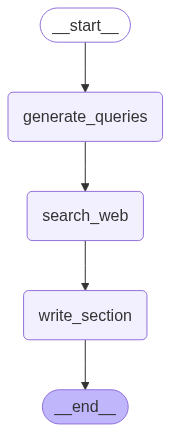

In [11]:
class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries
    queries = invoke_structured_llm_with_retry(structured_llm,
                                              [SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])

    # Write content to the section object
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Test with one section
sections = sections['sections']
test_section = sections[1]
print(f"{'='*50}")
print(f"Name: {test_section.name}")
print(f"Description: {test_section.description}")
print(f"Research: {test_section.research}")

# Run
report_section = await section_builder_graph.ainvoke({"section": test_section, "number_of_queries": 2, "tavily_topic": tavily_topic, "tavily_days": tavily_days})
from IPython.display import Markdown
section = report_section['completed_sections'][0]
Markdown(section.content)

Name: CPU
Description: Examine the core features, architecture, and implementation of CPU, and provide an example use case.
Research: True


## CPU Architecture and Performance
**The CPU market is highly competitive, with AMD and Intel offering high-performance processors**. The AMD Ryzen 9 7950X3D and Intel Core i9-14900K are top contenders, with the Ryzen 9 7950X3D offering stronger gaming performance. The CPU market is expected to see significant changes with the introduction of new architectures, such as AMD's Zen 5 and Intel's Arrow Lake.

Some key features of modern CPU architectures include:
* Improved IPC (Instructions Per Cycle)
* Higher clock speeds
* Increased core counts
* Enhanced security features

For example, the AMD Ryzen 7 9800X3D offers 8 cores and 16 threads, with a 4.7 GHz base clock and 5.2 GHz boost clock. This processor is well-suited for gaming and content creation workloads.

### Sources
- Best CPUs for Gaming: July 2024: https://www.anandtech.com/show/9793/best-cpus
- Which CPU brand is more popular in 2024? (Consumer grade desktop): https://www.reddit.com/r/buildapc/comments/1gilps1/which_cpu_brand_is_more_popular_in_2024_consumer/
- Best CPUs of 2024 (Intel vs. AMD): Gaming, Production, Budget, & Efficiency: https://www.tomshardware.com/reviews/best-cpus,3986.html
- The Best CPU for Gaming in 2025: https://www.tomshardware.com/reviews/best-cpus-for-gaming,3986.html
- CPU Benchmarks and Hierarchy 2025: CPU Rankings: https://www.tomshardware.com/reviews/cpu-hierarchy,4312.html
- CPU Architecture DEEP DIVE: https://pocketmags.com/us/maximum-pc-magazine/october-2024/articles/cpu-architecture-deep-dive?srsltid=AfmBOoo5UWqn7Jdfq6hys1boFelrXQ3C8Sxc_yViC66_4C4c8612Swk7
- Arm A-Profile Architecture Developments 2024: https://community.arm.com/arm-community-blogs/b/architectures-and-processors-blog/posts/arm-a-profile-architecture-developments-2024
- What's the best processor architecture currently, from a technical standpoint?: https://www.reddit.com/r/ECE/comments/1cygncn/whats_the_best_processor_architecture_currently/
- CPU Examples, Applications and Use Cases: https://www.ibm.com/think/topics/cpu-use-cases
- 5th Gen AMD EPYC Processor Architecture: https://www.amd.com/content/dam/amd/en/documents/epyc-business-docs/white-papers/5th-gen-amd-epyc-processor-architecture-white-paper.pdf

/tmp/ipython-input-2509919683.py:30: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send
/tmp/ipython-input-2509919683.py:145: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(ReportState, output=ReportStateOutput)


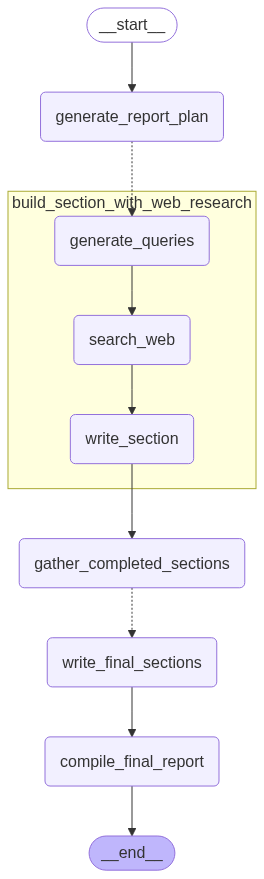

In [12]:
class ReportStateOutput(TypedDict):
    final_report: str # Final report

report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write:
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """

    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s,
                                                 "number_of_queries": state["number_of_queries"],
                                                 "tavily_topic": state["tavily_topic"],
                                                 "tavily_days": state.get("tavily_days", None)})
        for s in state["sections"]
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    section.content = section_content.content

    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """

    # for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
        for s in state["sections"]
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

To generate podcast or can be Added as an edge in the graph to create a podcast passing the final report

In [13]:
!pip install -U -q "google-genai>=1.16.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 6.0 MB/s eta 0:00:00


In [15]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [16]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [31]:
from google import genai
from google.genai import types
import wave

# Set up the wave file to save the output:
def wave_file(filename, pcm, channels=1, rate=24000, sample_width=2):
   with wave.open(filename, "wb") as wf:
      wf.setnchannels(channels)
      wf.setsampwidth(sample_width)
      wf.setframerate(rate)
      wf.writeframes(pcm)
def create_podcast_discussion(final_report, topic, filename="research_podcast.wav", configuration=None):
      script_prompt = f"""
    Create a natural, engaging podcast conversation between Dr. Sarah (research expert) and Mike (curious interviewer) about "{topic}".

    Use this research content:

  FINAL REPORT GENERATED BASED ON THE WEBSEARCH AND RESEARCH RESULTS:
  {final_report}

    Format as a dialogue with:
    - Mike introducing the topic and asking questions
    - Dr. Sarah explaining key concepts and insights
    - Natural back-and-forth discussion (5-7 exchanges)
    - Mike asking follow-up questions
    - Dr. Sarah synthesizing the main takeaways
    - Keep it conversational and accessible (2 or 3-4 minutes when spoken)

    Format exactly like this:
    Mike: [opening question]
    Dr. Sarah: [expert response]
    Mike: [follow-up]
    Dr. Sarah: [explanation]
    [continue...]
    """
      script_response = client.models.generate_content(
          model="gemini-2.5-flash",
          contents=script_prompt
      )
      podcast_script = script_response.candidates[0].content.parts[0].text
      tts_prompt = f"TTS the following conversation between Mike and Dr. Sarah:\n{podcast_script}"

      # Use default values if configuration is None
      tts_model = getattr(configuration, 'tts_model', "gemini-2.5-flash-preview-tts")
      mike_voice = getattr(configuration, 'mike_voice', 'Kore')
      sarah_voice = getattr(configuration, 'sarah_voice', 'Puck')
      tts_channels = getattr(configuration, 'tts_channels', 1)
      tts_rate = getattr(configuration, 'tts_rate', 24000)
      tts_sample_width = getattr(configuration, 'tts_sample_width', 2)


      response = client.models.generate_content(
          model=tts_model,
          contents=tts_prompt,
          config=types.GenerateContentConfig(
              response_modalities=["AUDIO"],
              speech_config=types.SpeechConfig(
                  multi_speaker_voice_config=types.MultiSpeakerVoiceConfig(
                      speaker_voice_configs=[
                          types.SpeakerVoiceConfig(
                              speaker='Mike',
                              voice_config=types.VoiceConfig(
                                  prebuilt_voice_config=types.PrebuiltVoiceConfig(
                                      voice_name=mike_voice,
                                  )
                              )
                          ),
                          types.SpeakerVoiceConfig(
                              speaker='Dr. Sarah',
                              voice_config=types.VoiceConfig(
                                  prebuilt_voice_config=types.PrebuiltVoiceConfig(
                                      voice_name=sarah_voice,
                                  )
                                )
                            ),
                        ]
                    )
                )
            )
        )
      audio_data = response.candidates[0].content.parts[0].inline_data.data
      wave_file(filename, audio_data, tts_channels, tts_rate, tts_sample_width)

      print(f"Podcast saved as: {filename}")
      return podcast_script, filename

# # Add nodes and edges
# builder = StateGraph(ReportState, output=ReportStateOutput)
# builder.add_node("generate_report_plan", generate_report_plan)
# builder.add_node("build_section_with_web_research", section_builder.compile())
# builder.add_node("gather_completed_sections", gather_completed_sections)
# builder.add_node("write_final_sections", write_final_sections)
# builder.add_node("compile_final_report", compile_final_report)
# builder.add_edge(START, "generate_report_plan")
# builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
# builder.add_edge("build_section_with_web_research", "gather_completed_sections")
# builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
# builder.add_edge("write_final_sections", "compile_final_report")
# builder.add_edge("compile_final_report", "create_podcast_discussion")
# builder.add_edge("create_podcast_discussion", END)

# graph = builder.compile()
# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
report_topic = "Give an overview of capabilities and specific use case examples for these processing units: CPU, GPU."
report = await graph.ainvoke({"topic": report_topic,
                                   "report_structure": report_structure,
                                   "number_of_queries": 2,
                                   "tavily_topic": tavily_topic,
                                   "tavily_days": tavily_days})
from IPython.display import Markdown
Markdown(report['final_report'])
#print the final report in plain text
report['final_report']

'# Introduction to CPU and GPU Comparison\nThe central processing unit (CPU) and graphics processing unit (GPU) are fundamental components of modern computing systems. Understanding their architectures and implementations is crucial for determining their performance and efficiency in various applications.\n\n## Context for Comparison\nThe CPU, or Central Processing Unit, is the brain of the computer, responsible for executing instructions and handling data. In contrast, the GPU is designed for massive parallel processing tasks, making it ideal for AI applications such as deep learning and computer vision. The comparison between CPU and GPU is essential for selecting the appropriate processing unit for specific use cases, including AI, gaming, and scientific simulations.\n\n## CPU Architecture\n**The core of modern computing, CPU architecture plays a crucial role in determining the performance and efficiency of a system**. The CPU, or Central Processing Unit, is the brain of the compute

In [32]:
final_report = report['final_report']
create_podcast_discussion(final_report, report_topic, filename="research_podcast.wav", configuration=None)

Podcast saved as: research_podcast.wav


('Mike: Welcome back to "Tech Demystified," the podcast where we break down complex concepts into everyday language. Today, we\'re diving into the very heart of computing, something crucial for everything from gaming to AI. Dr. Sarah, so glad to have you here to help us understand the capabilities and use cases for CPUs and GPUs. Let\'s start with the basics: What\'s the fundamental difference between a CPU and a GPU?\n\nDr. Sarah: Thanks, Mike! It\'s a great topic because these two components are fundamental. Think of the CPU, the Central Processing Unit, as the *brain* of your computer. It’s a generalist, incredibly good at executing instructions one after another, handling complex logic, and managing all the different parts of your system. It\'s responsible for the core operations, from running your operating system to opening your web browser.\n\nMike: So, the CPU is the master multi-tasker, the general manager. What about the GPU, the Graphics Processing Unit? We hear a lot about 

In [52]:
!pip install streamlit

In [53]:
%%writefile app.py
import asyncio
import streamlit as st
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3.3-70b-instruct",temperature=0.2,top_p=0.7)
import asyncio
from langsmith import traceable
from pydantic import BaseModel, Field
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()
def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
          Section {idx}: {section.name}
          Description:
          {section.description}
          Requires Research:
          {section.research}

          Content:
          {section.content if section.content else '[Not yet written]'}

          """
    return formatted_str

@traceable
def tavily_search(query):
    """ Search the web using the Tavily API.

    Args:
        query (str): The search query to execute

    Returns:
        dict: Tavily search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""

    return tavily_client.search(query,
                         max_results=5,
                         include_raw_content=True)

@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """

    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )
class SearchQuery(BaseModel):
    search_query: str = Field(
        None, description="Query for web search."
    )
class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

import operator
class ReportState(TypedDict):
  topic: str
  tavily_topic: Literal["general", "news"]
  tavily_days: Optional[int]
  report_structure: str
  number_of_queries: int
  sections: List[Section]
  completed_sections: Annotated[list, operator.add]
  report_sections_from_research: str
  final_report: str

from langchain_core.messages import HumanMessage, SystemMessage
report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report.

The report will be focused on the following topic:

{topic}

The report structure will follow these guidelines:

{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:

1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure."""

report_planner_instructions="""You are an expert technical writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:

{topic}

The report should follow this organization:

{report_organization}

You should reflect on this information to plan the sections of the report:

{context}

Now, generate the sections of the report. Each section should have the following fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web research. For example, introduction and conclusion will not require research because they will distill information from other parts of the report."""

report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

def invoke_structured_llm_with_retry(structured_llm, queries, max_attempts=3):
    for _ in range(max_attempts):
        results = structured_llm.invoke(queries)
        if results:
            return results
    return results

async def generate_report_plan(state: ReportState):

    topic = state["topic"]
    report_structure = state["report_structure"]
    number_of_queries = state["number_of_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    results = invoke_structured_llm_with_retry(structured_llm,[SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])
    query_list = [query.search_query for query in results.queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=True)
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str)
    structured_llm = llm.with_structured_output(Sections)
    report_sections = invoke_structured_llm_with_retry(structured_llm,[SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])
    return {"sections": report_sections.sections}

class SectionState(TypedDict):
    tavily_topic: Literal["general", "news"] # Tavily search topic
    tavily_days: Optional[int] # Only applicable for news topic
    number_of_queries: int # Number web search queries to perform per section
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

# Query writer instructions
query_writer_instructions="""Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material to help write the section:
{context}

5. Quality Checks:
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end"""

def generate_queries(state: SectionState):
    """ Generate search queries for a section """

    # Get state
    number_of_queries = state["number_of_queries"]
    section = state["section"]

    # Generate queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries
    queries = invoke_structured_llm_with_retry(structured_llm,
                                              [SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    tavily_topic = state["tavily_topic"]
    tavily_days = state.get("tavily_days", None)

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])

    # Write content to the section object
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Compile
section_builder_graph = section_builder.compile()

# View
display(Image(section_builder_graph.get_graph(xray=1).draw_mermaid_png()))
class ReportStateOutput(TypedDict):
    final_report: str # Final report

report_structure = """This report type focuses on comparative analysis.

The report structure should include:
1. Introduction (no research needed)
   - Brief overview of the topic area
   - Context for the comparison

2. Main Body Sections:
   - One dedicated section for EACH offering being compared in the user-provided list
   - Each section should examine:
     - Core Features (bulleted list)
     - Architecture & Implementation (2-3 sentences)
     - One example use case (2-3 sentences)

3. No Main Body Sections other than the ones dedicated to each offering in the user-provided list

4. Conclusion with Comparison Table (no research needed)
   - Structured comparison table that:
     * Compares all offerings from the user-provided list across key dimensions
     * Highlights relative strengths and weaknesses
   - Final recommendations"""

# Tavily search parameters
tavily_topic = "general"
tavily_days = None # Only applicable for news topic

from langgraph.constants import Send

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Section to write:
{section_topic}

Available report content:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response"""

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """

    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("build_section_with_web_research", {"section": s,
                                                 "number_of_queries": state["number_of_queries"],
                                                 "tavily_topic": state["tavily_topic"],
                                                 "tavily_days": state.get("tavily_days", None)})
        for s in state["sections"]
        if s.research
    ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section
    section_content = llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    section.content = section_content.content

    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research """

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ This is the "map" step when we kick off research on any sections that require it using the Send API """

    # for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
        for s in state["sections"]
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Add nodes and edges
builder = StateGraph(ReportState, output=ReportStateOutput)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan", initiate_section_writing, ["build_section_with_web_research"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

from google import genai
from google.genai import types
import wave

# Set up the wave file to save the output:
def wave_file(filename, pcm, channels=1, rate=24000, sample_width=2):
   with wave.open(filename, "wb") as wf:
      wf.setnchannels(channels)
      wf.setsampwidth(sample_width)
      wf.setframerate(rate)
      wf.writeframes(pcm)
def create_podcast_discussion(final_report, topic, filename="research_podcast.wav", configuration=None):
      script_prompt = f"""
    Create a natural, engaging podcast conversation between Dr. Sarah (research expert) and Mike (curious interviewer) about "{topic}".

    Use this research content:

  FINAL REPORT GENERATED BASED ON THE WEBSEARCH AND RESEARCH RESULTS:
  {final_report}

    Format as a dialogue with:
    - Mike introducing the topic and asking questions
    - Dr. Sarah explaining key concepts and insights
    - Natural back-and-forth discussion (5-7 exchanges)
    - Mike asking follow-up questions
    - Dr. Sarah synthesizing the main takeaways
    - Keep it conversational and accessible (2 or 3-4 minutes when spoken)

    Format exactly like this:
    Mike: [opening question]
    Dr. Sarah: [expert response]
    Mike: [follow-up]
    Dr. Sarah: [explanation]
    [continue...]
    """
      script_response = client.models.generate_content(
          model="gemini-2.5-flash",
          contents=script_prompt
      )
      podcast_script = script_response.candidates[0].content.parts[0].text
      tts_prompt = f"TTS the following conversation between Mike and Dr. Sarah:\n{podcast_script}"

      # Use default values if configuration is None
      tts_model = getattr(configuration, 'tts_model', "gemini-2.5-flash-preview-tts")
      mike_voice = getattr(configuration, 'mike_voice', 'Kore')
      sarah_voice = getattr(configuration, 'sarah_voice', 'Puck')
      tts_channels = getattr(configuration, 'tts_channels', 1)
      tts_rate = getattr(configuration, 'tts_rate', 24000)
      tts_sample_width = getattr(configuration, 'tts_sample_width', 2)


      response = client.models.generate_content(
          model=tts_model,
          contents=tts_prompt,
          config=types.GenerateContentConfig(
              response_modalities=["AUDIO"],
              speech_config=types.SpeechConfig(
                  multi_speaker_voice_config=types.MultiSpeakerVoiceConfig(
                      speaker_voice_configs=[
                          types.SpeakerVoiceConfig(
                              speaker='Mike',
                              voice_config=types.VoiceConfig(
                                  prebuilt_voice_config=types.PrebuiltVoiceConfig(
                                      voice_name=mike_voice,
                                  )
                              )
                          ),
                          types.SpeakerVoiceConfig(
                              speaker='Dr. Sarah',
                              voice_config=types.VoiceConfig(
                                  prebuilt_voice_config=types.PrebuiltVoiceConfig(
                                      voice_name=sarah_voice,
                                  )
                                )
                            ),
                        ]
                    )
                )
            )
        )
      audio_data = response.candidates[0].content.parts[0].inline_data.data
      wave_file(filename, audio_data, tts_channels, tts_rate, tts_sample_width)

      print(f"Podcast saved as: {filename}")
      return podcast_script, filename



Overwriting app.py


In [54]:
%%writefile app1.py
import asyncio
from app import report_structure, tavily_topic, tavily_days, graph, create_podcast_discussion

async def generate_report_and_podcast(topic, num_queries):
    report = await graph.ainvoke({
        "topic": topic,
        "report_structure": report_structure,
        "number_of_queries": num_queries,
        "tavily_topic": tavily_topic,
        "tavily_days": tavily_days
    })

    podcast_script, podcast_filename = create_podcast_discussion(report["final_report"], topic)
    return report, podcast_script, podcast_filename

st.title("📄 AI-Powered Report and Podcast Generator")
st.write(
    """
    Enter a topic below and hit **Generate**.
    The AI will fetch data, structure it according to your notebook’s
    `report_structure`, and display the final report.
    """
)

topic = st.text_input("🔍 Topic", placeholder="e.g. “Deep learning on edge devices”")
num_queries = st.slider("Number of AI queries (controls depth)", 1, 5, 2)

if st.button("Generate Report") and topic.strip():
    with st.spinner("Generating report and podcast…"):
        report, podcast_script, podcast_filename = asyncio.run(generate_report_and_podcast(topic, num_queries))

    st.subheader("Podcast Discussion")
    st.audio(podcast_filename)

    # Add download link for the podcast
    with open(podcast_filename, "rb") as f:
        st.download_button(
            label="Download Podcast",
            data=f,
            file_name=podcast_filename,
            mime="audio/wav"
        )

    st.subheader("Podcast Script")
    st.text_area("Script", podcast_script, height=300)

Overwriting app1.py


In [55]:
!wget -q -c https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.zip
!unzip -o ngrok-v3-stable-linux-amd64.zip
!chmod +x ngrok

Archive:  ngrok-v3-stable-linux-amd64.zip
  inflating: ngrok                   


In [56]:
!./ngrok config add-authtoken 2q9gHoz4I2P9TK9966QZ5snqfJ7_6gb71suopfXZf1Q3cENHe

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [57]:
!pip install pyngrok

In [58]:
from pyngrok import ngrok

# Kill all tunnels from previous sessions
ngrok.kill()

In [60]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Open the app here 👉", public_url)

# Relaunch Streamlit app
!streamlit run app1.py &> /dev/null &

Open the app here 👉 NgrokTunnel: "https://c28518dadbda.ngrok-free.app" -> "http://localhost:8501"
